In [1]:
# Given an image, run retrieval on it, extract metadata links, and google search those

In [1]:
%load_ext autoreload
%autoreload 2

In [59]:
from lib.inference import utils
from lib.inference import retrieval
from lib.taxonomy import loading as ld

import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import json

from inception import inception_model as inception

In [60]:
tf.__path__

['/home/esteva/anaconda/lib/python2.7/site-packages/tensorflow']

### Load metadata and training features/filenames

In [61]:
# Open up the metadata file and get the links
meta = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/meta.json'
meta = json.load(open(meta))
filename2meta = ld.Field2meta(meta, field='filename')

In [65]:
train_features.dtype

dtype('float32')

In [62]:
# Load features and filenames from the training set
train_features = '/media/esteva/ExtraDrive1/ThrunResearch/tf_experiments/nine-way/retrieve/trainset/train-features.npy'
train_filenames = '/media/esteva/ExtraDrive1/ThrunResearch/tf_experiments/nine-way/retrieve/trainset/train-filenames.txt'
train_features = np.load(train_features)
train_filenames = np.array([line.strip() for line in open(train_filenames).readlines()])

# Trim the features and filenames since they are highly redundant (due to buffer filling)
unique = []
for fn in train_filenames:
    name, ext = os.path.splitext(fn)
    ext = ext.replace('_','')
    assert ext in ['.jpg', '.png'], ext
    unique.append(name + ext)
train_filenames, indices = np.unique(unique, return_index=True)
train_features = train_features[indices]

### Infer image features and run retrieval

In [75]:
imagename = "/media/esteva/ExtraDrive1/ThrunResearch/data/firstderm/nevus/First_Derm_1a.jpg"
imagename = "/media/esteva/ExtraDrive1/ThrunResearch/data/firstderm/nevus/First_Derm_1b.jpg"
imagename = ('/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/'
            'images/httpwwwpharmacyanddrugscomillnessessimagesmycosisfungoides1jpg.jpg')
imagename = "/media/esteva/ExtraDrive1/ThrunResearch/data/firstderm/melanoma/Melanom_2_b_John_Paoli_iDoc24.JPG"
imagename = "/media/esteva/ExtraDrive1/ThrunResearch/data/firstderm/melanoma/Melanom_1_b_John_Paoli_iDoc24.JPG"

# imagename = "/media/esteva/ExtraDrive1/ThrunResearch/data/example_images/Basal_cell_carcinoma.jpg"

# Psoriasis is a beautiful demo...
# imagename = "/media/esteva/ExtraDrive1/ThrunResearch/data/firstderm/psoriasis/Psoriasis_5a.jpg"
imagename = "/media/esteva/ExtraDrive1/ThrunResearch/data/firstderm/psoriasis/Psoriasis_3a.jpg"
# imagename = "/media/esteva/ExtraDrive1/ThrunResearch/data/firstderm/dermatitis/Dermatitis_1a.jpg"

#Sebastian's head - great results up close (head3), bad results from far away (head1)
# imagename = "/media/esteva/ExtraDrive1/ThrunResearch/data/example_images/sebastian_head1.jpg"
# imagename = "/media/esteva/ExtraDrive1/ThrunResearch/data/example_images/sebastian_head3.jpg"


# Network to load
features_tensor_name = 'inception_v3/logits/flatten/Reshape:0'

num_classes = 9; checkpoint_dir = '/media/esteva/ExtraDrive1/ThrunResearch/tf_experiments/production/nine-way/train'
# num_classes = 759; checkpoint_dir = '/media/esteva/ExtraDrive1/ThrunResearch/tf_experiments/recursive_dividing_N=1000/train'

imbuffer = tf.gfile.FastGFile(imagename, 'r').read()
with tf.Graph().as_default(), tf.Session() as sess:
    image_op, buffer_op = utils.filename2image()
    
    
    _,_ = inception.inference(image_op, num_classes + 1, restore_logits=False)
    utils.load_checkpoint(checkpoint_dir, sess)
    features_tensor = tf.get_default_graph().get_tensor_by_name(features_tensor_name)
    
    # Extract features for the image
    features, image = sess.run([features_tensor, image_op], feed_dict={buffer_op : imbuffer})
    
# Retrieve
topN, distsN = retrieval.retrieve(train_features, features, 9)
neighbors = train_filenames[topN]

Succesfully loaded model from model.ckpt-185000 at step=185000.


In [76]:
neighbors

array([ 'httpwwwdermaamincomsiteimagesclinicalpicLlymediseaselymedisease12jpg.jpg',
       'httpwwwatlasdermatologicocombrimgimageId5549.jpg',
       'httpwwwdermnetcomdn2allJPG3tineabody220jpg.jpg',
       'httpwwwskinsightcomimagesdxwebInfantcellulitis28465lgjpg.jpg',
       'httpwwwdermnetcomdn2allJPG3LichenSclerosusSkin113jpg.jpg',
       'httpwwwdermnetcomdn2allJPG3tineabody174jpg.jpg',
       'httpwwwdermnetcomdn2allJPG3lichensimplexchronicus173jpg.jpg',
       'httpwwwdermnetcomdn2allJPG3KeratosisIMG004GP3jpg.jpg',
       'httpwwwdermnetcomdn2allJPG3eczemasubacute50jpg.jpg'], 
      dtype='|S212')

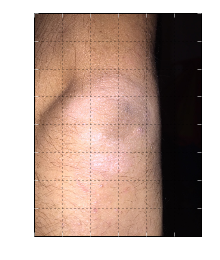

In [78]:
plt.imshow(plt.imread(imagename))
plt.show()

In [77]:
def print_field(neighbors, field):
    for fn in neighbors:
        m = filename2meta(fn)
        if isinstance(m, list):
            for mm in m:
                if field in mm:
                    print mm[field]
        else:
            print m[field]

# Print neighbors
print neighbors
print ''
            
# Print nn labels & urls
print_field(neighbors, 'label')
print ''
print_field(neighbors, 'link')
print ''
print_field(neighbors, 'caption')
            

['httpwwwdermaamincomsiteimagesclinicalpicLlymediseaselymedisease12jpg.jpg'
 'httpwwwatlasdermatologicocombrimgimageId5549.jpg'
 'httpwwwdermnetcomdn2allJPG3tineabody220jpg.jpg'
 'httpwwwskinsightcomimagesdxwebInfantcellulitis28465lgjpg.jpg'
 'httpwwwdermnetcomdn2allJPG3LichenSclerosusSkin113jpg.jpg'
 'httpwwwdermnetcomdn2allJPG3tineabody174jpg.jpg'
 'httpwwwdermnetcomdn2allJPG3lichensimplexchronicus173jpg.jpg'
 'httpwwwdermnetcomdn2allJPG3KeratosisIMG004GP3jpg.jpg'
 'httpwwwdermnetcomdn2allJPG3eczemasubacute50jpg.jpg']

inflammatory
inflammatory
inflammatory
inflammatory
inflammatory
inflammatory
inflammatory
inflammatory
inflammatory

http://www.dermaamin.com/site/images/clinical-pic/L/lyme-disease/lyme-disease12.jpg
http://www.atlasdermatologico.com.br/img?imageId=5549
http://www.dermnet.com/dn2/allJPG3/tinea-body-220.jpg
http://www.skinsight.com/images/dx/webInfant/cellulitis_28465_lg.jpg
http://www.dermnet.com/dn2/allJPG3/Lichen-Sclerosus-Skin-113.jpg
http://www.dermnet.com/dn2/al

In [185]:
fn = neighbors[0]
filename2meta(fn)

[{u'caption': u'Basal Cell Carcinoma',
  u'case': 2365,
  u'database': u'dermquest',
  u'exif': {},
  u'filename': u'httpswwwdermquestcomimagelibrarylarge000939HBJPG.jpg',
  u'label': u'epidermal malignant',
  u'label_clean': u'basal cell carcinoma',
  u'label_clean_ok': True,
  u'link': u'https://www.dermquest.com/imagelibrary/large/000939HB.JPG',
  u'skin_prob': 0.988177478313446,
  u'tax_path': [[u'epidermal',
    u'tumors',
    u'pre',
    u'malignant',
    u'and',
    u'malignant'],
   [u'basal', u'cell', u'carcinoma'],
   [u'basal', u'cell', u'carcinoma']],
  u'tax_path_score': 1.0,
  u'tries': 0}]

In [213]:
import urllib
# image = urllib.URLopener()
im = urllib.urlopen("http://www.gunnerkrigg.com//comics/00000001.jpg").read()

### These are the big domains that you want to include in search

In [ ]:
links = ld.getEntryValues(meta, 'link')

In [191]:
from urlparse import urlparse

def get_domain(url):
    """Returns http://www.google.com from http://www.google.com/lots-of-crap"""
    parsed_uri = urlparse(url)
    domain = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)
    return domain

get_domain(links[0])

'http://www.atlasdermatologico.com.br/'

In [196]:
domains, counts = np.unique([get_domain(l) for l in links], return_counts=True)

In [208]:
big_domains = domains[counts > 1000]
print len(big_domains)

25


In [207]:
for b in big_domains:
    print b

http://1.bp.blogspot.com/
http://dermaamin.com/
http://dermatologyoasis.net/
http://dermatoweb2.udl.es/
http://enzyklopaedie-dermatologie.de/
http://escholarship.org/
http://i.ytimg.com/
http://image.slidesharecdn.com/
http://img.medscape.com/
http://img.medscapestatic.com/
http://regionalderm.com/
http://www.atlasdermatologico.com.br/
http://www.derm101.com/
http://www.dermaamin.com/
http://www.dermis.net/
http://www.dermnet.com/
http://www.globalskinatlas.com/
http://www.hellenicdermatlas.com/
http://www.ijdvl.com/
http://www.scielo.br/
http://www.skinsight.com/
https://classconnection.s3.amazonaws.com/
https://s-media-cache-ak0.pinimg.com/
https://upload.wikimedia.org/
https://www.dermquest.com/


### We'll use a meta file with the following fields:
 - link (to display images from the web
 - caption (to run google search)
 - label (to know the diagnosis)
 - filename (to match from features)

In [57]:
meta[0]

{u'caption': u'acanthosis nigricans-benign',
 u'database': u'atlas',
 u'exif': {},
 u'filename': u'httpwwwatlasdermatologicocombrimgimageId1.jpg',
 u'label': u'inflammatory',
 u'label_clean': u'acanthosis nigricans benign',
 u'link': u'http://www.atlasdermatologico.com.br/img?imageId=1',
 u'skin_prob': 0.6326977610588074,
 u'tax_path': [[u'inflammatory'],
  [u'acanthosis', u'nigricans', u'and', u'carp'],
  [u'acanthosis', u'nigricans', u'benign']],
 u'tax_path_score': 1.0,
 u'tries': 0}

In [ ]:
meta_app = []
kept_fields = #WHENCE!!!!
for m in meta:
    mm = {}
    mm[]

In [7]:
import subprocess as sp
c = '/media/esteva/ExtraDrive1/ThrunResearch/tensorflow_master/serving/bazel-bin/tensorflow_serving/example/inception_client'
c += ' --server=localhost:9000'
c += ' --image=/home/esteva/Downloads/Melanoma.jpg'
o = sp.check_output(c.split())

In [45]:
print o

outputs {
  key: "classes"
  value {
    dtype: DT_STRING
    tensor_shape {
      dim {
        size: 1
      }
      dim {
        size: 9
      }
    }
    string_val: "pigmented-lesion-malignant"
    string_val: "pigmented-lesion-benign"
    string_val: "dermal-tumor-benign"
    string_val: "dermal-tumor-malignant"
    string_val: "cutaneous-lymphoma"
    string_val: "genodermatosis"
    string_val: "epidermal-tumor-malignant"
    string_val: "unused background"
    string_val: "inflammatory"
  }
}
outputs {
  key: "features"
  value {
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: 1
      }
      dim {
        size: 2048
      }
    }
    float_val: 0.0872103348374
    float_val: 0.0980975031853
    float_val: 0.0592767223716
    float_val: 0.0430302545428
    float_val: 0.103699252009
    float_val: 0.0302207693458
    float_val: 0.134597748518
    float_val: 0.385213434696
    float_val: 0.104130163789
    float_val: 0.176080673933
    float_val: 0.077807903289

In [46]:
def get_output_blocks_from_protostring(pstring):
    """Returns the proto output of, say 'features', or 'scores', or 'classes' from a protobuf string."""
    pstring = pstring.strip().split('\n')
    outputs = []
    start_locations = []
    for i, line in enumerate(pstring):        
        if 'outputs' in line:
            start_locations.append(i)
    start_locations.append(len(pstring))    
    for start, end in zip(start_locations[:-1], start_locations[1:]):
        
        outputs.append(pstring[start:end])
    return outputs
        
    
def output_block(pstring, blockname):
    """Returns 'features', or 'scores', or 'classes', block."""
    key = 'key: "%s"' % blockname    
    outputs = get_output_blocks_from_protostring(pstring)
    for output in outputs:
        for line in output:
            if key in line:
                return output
    
def get_features_from_protostring(pstring):
    """Returns the image features as a numpy array."""
    features_block = output_block(pstring, 'features')
    features = []
    for line in features_block:
        if 'float_val:' in line:
            features.append(line.split()[-1])
    return np.array(features)


def get_classes_from_protostring(pstring):
    """Returns the image features as a numpy array."""
    features_block = output_block(pstring, 'classes')
    features = []
    for line in features_block:
        if 'string_val:' in line:
            features.append(line.split()[-1])
    return np.array(features)


def get_scores_from_protostring(pstring):
    """Returns the image features as a numpy array."""
    features_block = output_block(pstring, 'scores')
    features = []
    for line in features_block:
        if 'float_val:' in line:
            features.append(line.split()[-1])
    return np.array(features)


output = output_block(o, 'features')
features = get_features_from_protostring(o)
classes = get_classes_from_protostring(o)
scores = get_scores_from_protostring(o)

# def get_features_from_protostring(pstring):
#     """Returns the image features from a protobuf-formatted string."""
#     pstring = pstring.strip().split()
#     for line in pstring:
#         lookout = False
#         if line == 'key: "features"':
#             lookout = True
#         if 'float_val'
        
            